# CIFAR10 Transfer Learning based Classifier

This notebook outlines the steps to build a classifier to leverage concepts of Transfer Learning by utilizing a pretrained Deep-CNN.
Particularly in this case based on VGG16

In [1]:

import numpy as np
import matplotlib.pyplot as plt
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}

plt.rcParams.update(params)


def make_prediction(model=None,img_vector=[],
                    label_dict={},top_N=3,
                    model_input_shape=None):
    if model:
        # get model input shape
        if not model_input_shape:
            model_input_shape = (1,)+model.get_input_shape_at(0)[1:]

        # get prediction
        prediction = model.predict(img_vector.reshape(model_input_shape))[0]


        # get top N with confidence
        labels_predicted = [label_dict[idx] for idx in np.argsort(prediction)[::-1][:top_N]]
        confidence_predicted = np.sort(prediction)[::-1][:top_N]

        return labels_predicted, confidence_predicted


def plot_predictions(model,dataset,
                    dataset_labels,label_dict,
                    batch_size,grid_height,grid_width):
    if model:
        f, ax = plt.subplots(grid_width, grid_height)
        f.set_size_inches(12, 12)

        random_batch_indx = np.random.permutation(np.arange(0,len(dataset)))[:batch_size]

        img_idx = 0
        for i in range(0, grid_width):
            for j in range(0, grid_height):
                actual_label = label_dict.get(dataset_labels[random_batch_indx[img_idx]].argmax())
                preds,confs_ = make_prediction(model,
                                              img_vector=dataset[random_batch_indx[img_idx]],
                                              label_dict=label_dict,
                                              top_N=1)
                ax[i][j].axis('off')
                ax[i][j].set_title('Actual:'+actual_label[:10]+\
                                    '\nPredicted:'+preds[0] + \
                                    '(' +str(round(confs_[0],2)) + ')')
                ax[i][j].imshow(dataset[random_batch_indx[img_idx]])
                img_idx += 1

        plt.subplots_adjust(left=0, bottom=0, right=1,
                            top=1, wspace=0.4, hspace=0.55)


# source: https://github.com/keras-team/keras/issues/431#issuecomment-317397154
def get_activations(model, model_inputs,
    print_shape_only=True, layer_name=None):
    import keras.backend as K
    print('----- activations -----')
    activations = []
    inp = model.input

    model_multi_inputs_cond = True
    if not isinstance(inp, list):
        # only one input! let's wrap it in a list.
        inp = [inp]
        model_multi_inputs_cond = False
    # all layer outputs
    outputs = [layer.output for layer in model.layers if
               layer.name == layer_name or layer_name is None]

    # evaluation functions
    funcs = [K.function(inp + [K.learning_phase()], [out]) for out in outputs]

    if model_multi_inputs_cond:
        list_inputs = []
        list_inputs.extend(model_inputs)
        list_inputs.append(1.)
    else:
        list_inputs = [model_inputs, 1.]

    # Learning phase. 1 = Test mode (no dropout or batch normalization)
    # layer_outputs = [func([model_inputs, 1.])[0] for func in funcs]
    layer_outputs = [func(list_inputs)[0] for func in funcs]
    for layer_activations in layer_outputs:
        activations.append(layer_activations)
        if print_shape_only:
            print(layer_activations.shape)
        else:
            print(layer_activations)
    return activations

# source :https://github.com/philipperemy/keras-visualize-activations/blob/master/read_activations.py
def display_activations(activation_maps):
    batch_size = activation_maps[0].shape[0]
    assert batch_size == 1, 'One image at a time to visualize.'
    for i, activation_map in enumerate(activation_maps):
        print('Displaying activation map {}'.format(i))
        shape = activation_map.shape
        if len(shape) == 4:
            activations = np.hstack(np.transpose(activation_map[0], (2, 0, 1)))
        elif len(shape) == 2:
            # try to make it square as much as possible. we can skip some activations.
            activations = activation_map[0]
            num_activations = len(activations)
            # too hard to display it on the screen.
            if num_activations > 1024:
                square_param = int(np.floor(np.sqrt(num_activations)))
                activations = activations[0: square_param * square_param]
                activations = np.reshape(activations, (square_param, square_param))
            else:
                activations = np.expand_dims(activations, axis=0)
        else:
            raise Exception('len(shape) = 3 has not been implemented.')
        #plt.imshow(activations, interpolation='None', cmap='binary')
        fig, ax = plt.subplots(figsize=(18, 12))
        ax.imshow(activations, interpolation='None', cmap='binary')
        plt.show()

In [2]:
from sklearn import metrics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.base import clone
from sklearn.preprocessing import label_binarize
from scipy import interp
from sklearn.metrics import roc_curve, auc


def get_metrics(true_labels, predicted_labels):

    print('Accuracy:', np.round(
                        metrics.accuracy_score(true_labels,
                                               predicted_labels),
                        4))
    print('Precision:', np.round(
                        metrics.precision_score(true_labels,
                                               predicted_labels,
                                               average='weighted'),
                        4))
    print('Recall:', np.round(
                        metrics.recall_score(true_labels,
                                               predicted_labels,
                                               average='weighted'),
                        4))
    print('F1 Score:', np.round(
                        metrics.f1_score(true_labels,
                                               predicted_labels,
                                               average='weighted'),
                        4))


def train_predict_model(classifier,
                        train_features, train_labels,
                        test_features, test_labels):
    # build model
    classifier.fit(train_features, train_labels)
    # predict using model
    predictions = classifier.predict(test_features)
    return predictions


def display_confusion_matrix(true_labels, predicted_labels, classes=[1,0]):

    total_classes = len(classes)
    level_labels = [total_classes*[0], list(range(total_classes))]

    cm = metrics.confusion_matrix(y_true=true_labels, y_pred=predicted_labels,
                                  labels=classes)
    cm_frame = pd.DataFrame(data=cm,
                            columns=pd.MultiIndex(levels=[['Predicted:'], classes],
                                                  labels=level_labels),
                            index=pd.MultiIndex(levels=[['Actual:'], classes],
                                                labels=level_labels))
    print(cm_frame)

def display_classification_report(true_labels, predicted_labels, classes=[1,0]):

    report = metrics.classification_report(y_true=true_labels,
                                           y_pred=predicted_labels,
                                           labels=classes)
    print(report)



def display_model_performance_metrics(true_labels, predicted_labels, classes=[1,0]):
    print('Model Performance metrics:')
    print('-'*30)
    get_metrics(true_labels=true_labels, predicted_labels=predicted_labels)
    print('\nModel Classification report:')
    print('-'*30)
    display_classification_report(true_labels=true_labels, predicted_labels=predicted_labels,
                                  classes=classes)
    print('\nPrediction Confusion Matrix:')
    print('-'*30)
    display_confusion_matrix(true_labels=true_labels, predicted_labels=predicted_labels,
                             classes=classes)


def plot_model_decision_surface(clf, train_features, train_labels,
                                plot_step=0.02, cmap=plt.cm.RdYlBu,
                                markers=None, alphas=None, colors=None):

    if train_features.shape[1] != 2:
        raise ValueError("X_train should have exactly 2 columnns!")

    x_min, x_max = train_features[:, 0].min() - plot_step, train_features[:, 0].max() + plot_step
    y_min, y_max = train_features[:, 1].min() - plot_step, train_features[:, 1].max() + plot_step
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    clf_est = clone(clf)
    clf_est.fit(train_features,train_labels)
    if hasattr(clf_est, 'predict_proba'):
        Z = clf_est.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,1]
    else:
        Z = clf_est.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=cmap)

    le = LabelEncoder()
    y_enc = le.fit_transform(train_labels)
    n_classes = len(le.classes_)
    plot_colors = ''.join(colors) if colors else [None] * n_classes
    label_names = le.classes_
    markers = markers if markers else [None] * n_classes
    alphas = alphas if alphas else [None] * n_classes
    for i, color in zip(range(n_classes), plot_colors):
        idx = np.where(y_enc == i)
        plt.scatter(train_features[idx, 0], train_features[idx, 1], c=color,
                    label=label_names[i], cmap=cmap, edgecolors='black',
                    marker=markers[i], alpha=alphas[i])
    plt.legend()
    plt.show()


def plot_model_roc_curve(clf, features, true_labels, label_encoder=None, class_names=None):

    ## Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    if hasattr(clf, 'classes_'):
        class_labels = clf.classes_
    elif label_encoder:
        class_labels = label_encoder.classes_
    elif class_names:
        class_labels = class_names
    else:
        raise ValueError('Unable to derive prediction classes, please specify class_names!')
    n_classes = len(class_labels)
    y_test = label_binarize(true_labels, classes=class_labels)
    if n_classes == 2:
        if hasattr(clf, 'predict_proba'):
            prob = clf.predict_proba(features)
            y_score = prob[:, prob.shape[1]-1]
        elif hasattr(clf, 'decision_function'):
            prob = clf.decision_function(features)
            y_score = prob[:, prob.shape[1]-1]
        else:
            raise AttributeError("Estimator doesn't have a probability or confidence scoring system!")

        fpr, tpr, _ = roc_curve(y_test, y_score)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label='ROC curve (area = {0:0.2f})'
                                 ''.format(roc_auc),
                 linewidth=2.5)

    elif n_classes > 2:
        if hasattr(clf, 'predict_proba'):
            y_score = clf.predict_proba(features)
        elif hasattr(clf, 'decision_function'):
            y_score = clf.decision_function(features)
        else:
            raise AttributeError("Estimator doesn't have a probability or confidence scoring system!")

        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        ## Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

        ## Compute macro-average ROC curve and ROC area
        # First aggregate all false positive rates
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
        # Then interpolate all ROC curves at this points
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(n_classes):
            mean_tpr += interp(all_fpr, fpr[i], tpr[i])
        # Finally average it and compute AUC
        mean_tpr /= n_classes
        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

        ## Plot ROC curves
        plt.figure(figsize=(6, 4))
        plt.plot(fpr["micro"], tpr["micro"],
                 label='micro-average ROC curve (area = {0:0.2f})'
                       ''.format(roc_auc["micro"]), linewidth=3)

        plt.plot(fpr["macro"], tpr["macro"],
                 label='macro-average ROC curve (area = {0:0.2f})'
                       ''.format(roc_auc["macro"]), linewidth=3)

        for i, label in enumerate(class_labels):
            plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                           ''.format(label, roc_auc[i]),
                     linewidth=2, linestyle=':')
    else:
        raise ValueError('Number of classes should be atleast 2 or more')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

In [3]:
# Pandas and Numpy for data structures and util fucntions
import scipy as sp
import numpy as np
import pandas as pd
from numpy.random import rand
pd.options.display.max_colwidth = 600

# Scikit Imports
from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.model_selection import train_test_split

# Matplot Imports
import matplotlib.pyplot as plt
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}

plt.rcParams.update(params)
%matplotlib inline

# pandas display data frames as tables
from IPython.display import display, HTML

import warnings
warnings.filterwarnings('ignore')

In [4]:
import tensorflow as tf
from keras import callbacks
from keras import optimizers
from keras.datasets import cifar10
from keras import Model
from keras.applications import vgg16 as vgg
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D,BatchNormalization
from keras.preprocessing.image import ImageDataGenerator

## Load and Prepare DataSet

In [5]:
BATCH_SIZE = 32
EPOCHS = 40
NUM_CLASSES = 10
LEARNING_RATE = 1e-4
MOMENTUM = 0.9

In [6]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

Split training dataset in train and validation sets

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                  y_train,
                                                  test_size=0.15,
                                                  stratify=np.array(y_train),
                                                  random_state=42)

Transform target variable/labels into one hot encoded form

In [8]:
from tensorflow.keras.utils import to_categorical
Y_train = to_categorical(y_train, NUM_CLASSES)
Y_val = to_categorical(y_val, NUM_CLASSES)
Y_test = to_categorical(y_test, NUM_CLASSES)

### Preprocessing

Since we are about to use VGG16 as a feature extractor, the minimum size of an image it takes is 48x48.
We utilize ```scipy`` to resize images to required dimensions

In [9]:
from skimage.transform import resize

In [10]:
X_train = np.array([resize(x, (48, 48)) for x in X_train])
X_val = np.array([resize(x,(48, 48)) for x in X_val])
X_test = np.array([resize(x,(48, 48)) for x in X_test])

## Prepare the Model

* Load VGG16 without the top classification layer
* Prepare a custom classifier
* Stack both models on top of each other

In [12]:
base_model = vgg.VGG16(weights='imagenet',
                       include_top=False,
                       input_shape=(48, 48, 3))

58889256/58889256 [==============================] - 0s 0us/step


In [13]:
# Extract the last layer from third block of vgg16 model
last = base_model.get_layer('block3_pool').output

In [14]:
# Add classification layers on top of it
x = GlobalAveragePooling2D()(last)
x= BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.6)(x)
pred = Dense(NUM_CLASSES, activation='softmax')(x)
model = Model(base_model.input, pred)

Since our objective is to only train the custom classifier, we freeze the layers of VGG16

In [15]:
for layer in base_model.layers:
     layer.trainable = False

In [16]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=LEARNING_RATE),
              metrics=['accuracy'])

In [17]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

## Data Augmentation

To help model generalize and overcome the limitations of a small dataset, we prepare augmented datasets using
```keras ``` utilities

In [11]:
# prepare data augmentation configuration
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    horizontal_flip=False)

In [12]:
train_datagen.fit(X_train)
train_generator = train_datagen.flow(X_train,
                                     Y_train,
                                     batch_size=BATCH_SIZE)

In [13]:
val_datagen = ImageDataGenerator(rescale=1. / 255,
    horizontal_flip=False)

val_datagen.fit(X_val)
val_generator = val_datagen.flow(X_val,
                                 Y_val,
                                 batch_size=BATCH_SIZE)

In [14]:
train_steps_per_epoch = X_train.shape[0] // BATCH_SIZE
val_steps_per_epoch = X_val.shape[0] // BATCH_SIZE

## Train the Model

In [21]:


history = model.fit_generator(train_generator,
                              steps_per_epoch=train_steps_per_epoch,
                              validation_data=val_generator,
                              validation_steps=val_steps_per_epoch,
                              epochs=EPOCHS,
                              verbose=1)

Epoch 1/40
1328/1328 [==============================] - 23s 10ms/step - loss: 0.2371 - accuracy: 0.4645 - val_loss: 0.1902 - val_accuracy: 0.5747
Epoch 2/40
1328/1328 [==============================] - 14s 11ms/step - loss: 0.1981 - accuracy: 0.5636 - val_loss: 0.1745 - val_accuracy: 0.6159
Epoch 3/40
1328/1328 [==============================] - 12s 9ms/step - loss: 0.1854 - accuracy: 0.5952 - val_loss: 0.1679 - val_accuracy: 0.6295
Epoch 4/40
1328/1328 [==============================] - 12s 9ms/step - loss: 0.1772 - accuracy: 0.6166 - val_loss: 0.1660 - val_accuracy: 0.6380
Epoch 5/40
1328/1328 [==============================] - 13s 10ms/step - loss: 0.1710 - accuracy: 0.6334 - val_loss: 0.1613 - val_accuracy: 0.6433
Epoch 6/40
1328/1328 [==============================] - 13s 10ms/step - loss: 0.1658 - accuracy: 0.6423 - val_loss: 0.1587 - val_accuracy: 0.6516
Epoch 7/40
1328/1328 [==============================] - 13s 10ms/step - loss: 0.1619 - accuracy: 0.6531 - val_loss: 0.1567 - v

## Analyze Model Performance

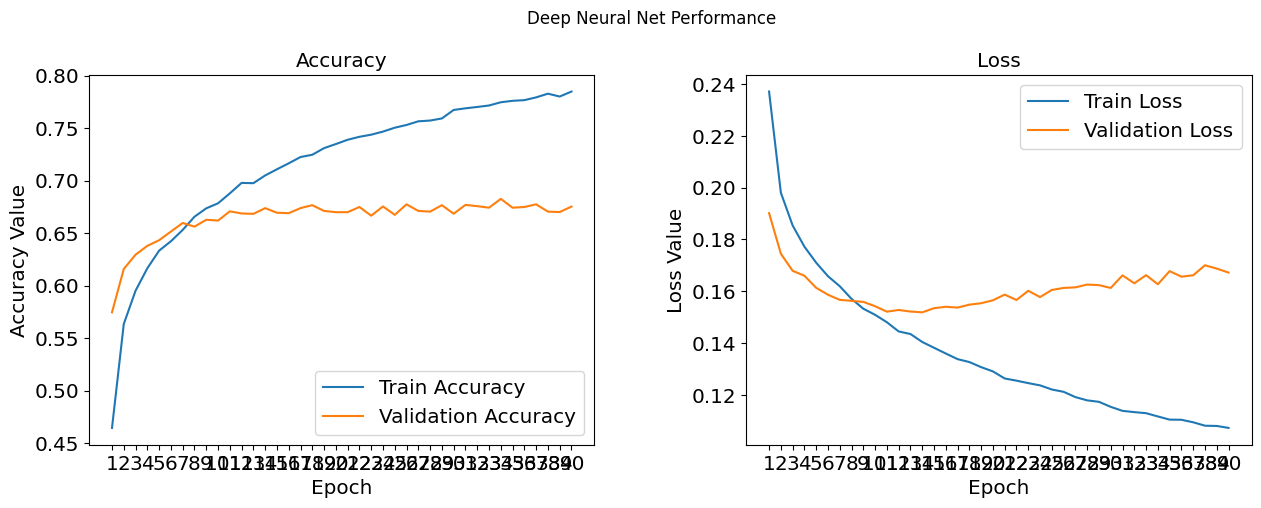

In [23]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
t = f.suptitle('Deep Neural Net Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epochs = list(range(1,EPOCHS+1))
ax1.plot(epochs, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(epochs)
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epochs, history.history['loss'], label='Train Loss')
ax2.plot(epochs, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(epochs)
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [24]:
predictions = model.predict(X_test/255.)

313/313 [==============================] - 2s 6ms/step


In [25]:
test_labels = list(y_test.squeeze())
predictions = list(predictions.argmax(axis=1))

In [26]:
get_metrics(true_labels=y_test,
                predicted_labels=predictions)

Accuracy: 0.6826
Precision: 0.683
Recall: 0.6826
F1 Score: 0.6817


## Visualize Predictions

In [27]:
label_dict = {0:'airplane',
             1:'automobile',
             2:'bird',
             3:'cat',
             4:'deer',
             5:'dog',
             6:'frog',
             7:'horse',
             8:'ship',
             9:'truck'}

In [ ]:
classes=['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
R = 5
C = 5
fig, axes = plt.subplots(R, C, figsize=(12,12))
axes = axes.ravel()

for i in np.arange(0, R*C):
  axes[i].imshow(X_test[i])
  axes[i].set_title("True: %s \nPredict: %s" %(classes[np.argmax(Y_test[i])],
                                               classes[predictions[i]]))
  axes[i].axis('off')
  plt.subplots_adjust(wspace=1)

## Xception

In [15]:
import keras

In [16]:
base_model = keras.applications.Xception(weights='imagenet',
                       include_top=False,
                      input_shape = (299, 299, 3))

In [17]:
# Extract the last layer from third block of vgg16 model
last = base_model.get_layer('block3_pool').output

In [18]:
# Add classification layers on top of it
x = GlobalAveragePooling2D()(last)
x= BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.6)(x)
pred = Dense(NUM_CLASSES, activation='softmax')(x)
Xception_model = Model(base_model.input, pred)

In [19]:
for layer in base_model.layers:
     layer.trainable = False

In [20]:
Xception_model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=LEARNING_RATE),
              metrics=['accuracy'])

In [21]:
Xception_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 149, 149, 32)         864       ['input_1[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 149, 149, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 149, 149, 32)         0         ['block1_conv1_bn[0][0]'] 

In [22]:
history = Xception_model.fit_generator(train_generator,
                              steps_per_epoch=train_steps_per_epoch,
                              validation_data=val_generator,
                              validation_steps=val_steps_per_epoch,
                              epochs=EPOCHS,
                              verbose=1)

Epoch 1/40
1328/1328 [==============================] - 19s 9ms/step - loss: 0.2440 - accuracy: 0.4430 - val_loss: 0.2011 - val_accuracy: 0.5483
Epoch 2/40
1328/1328 [==============================] - 10s 8ms/step - loss: 0.2061 - accuracy: 0.5451 - val_loss: 0.1854 - val_accuracy: 0.5841
Epoch 3/40
1328/1328 [==============================] - 10s 8ms/step - loss: 0.1941 - accuracy: 0.5759 - val_loss: 0.1791 - val_accuracy: 0.6028
Epoch 4/40
1328/1328 [==============================] - 9s 7ms/step - loss: 0.1854 - accuracy: 0.5984 - val_loss: 0.1726 - val_accuracy: 0.6209
Epoch 5/40
1328/1328 [==============================] - 12s 9ms/step - loss: 0.1777 - accuracy: 0.6189 - val_loss: 0.1728 - val_accuracy: 0.6217
Epoch 6/40
1328/1328 [==============================] - 9s 7ms/step - loss: 0.1733 - accuracy: 0.6285 - val_loss: 0.1692 - val_accuracy: 0.6310
Epoch 7/40
1328/1328 [==============================] - 16s 12ms/step - loss: 0.1690 - accuracy: 0.6395 - val_loss: 0.1654 - val_acc

In [23]:
Xception_model.save("Xception_model.h5")

In [ ]:
import numpy as np
import cv2

def resize_images(images, target_size=(299, 299)):
    for img in images:
        yield cv2.resize(img, target_size)

def predict_in_batches(model, images, batch_size=32):
    for i in range(0, len(images), batch_size):
        batch = images[i:i + batch_size]
        batch_resized = np.array(list(resize_images(batch)))
        yield model.predict(batch_resized / 255.)

# Assuming X_test is a numpy array of shape (num_samples, 48, 48, 3)
# and Xception_model is your model

# Process the images in batches
batch_predictions = list(predict_in_batches(Xception_model, X_test))

# Concatenate the predictions from each batch
predictions = np.concatenate(batch_predictions, axis=0)

## ResNet50

In [24]:
base_model = keras.applications.ResNet50(weights='imagenet',
                       include_top=False,
                       input_shape= (224, 224, 3))

94765736/94765736 [==============================] - 0s 0us/step


In [26]:
# Extract the last layer from third block of vgg16 model
last = base_model.get_layer('conv3_block3_1_conv').output

In [27]:
# Add classification layers on top of it
x = GlobalAveragePooling2D()(last)
x= BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.6)(x)
pred = Dense(NUM_CLASSES, activation='softmax')(x)
ResNet50_model = Model(base_model.input, pred)

In [28]:
for layer in base_model.layers:
     layer.trainable = False

In [29]:
ResNet50_model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=LEARNING_RATE),
              metrics=['accuracy'])

In [30]:
ResNet50_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [32]:
history = ResNet50_model.fit_generator(train_generator,
                              steps_per_epoch=train_steps_per_epoch,
                              validation_data=val_generator,
                              validation_steps=val_steps_per_epoch,
                              epochs=EPOCHS,
                              verbose=1)

Epoch 1/40
1328/1328 [==============================] - 24s 15ms/step - loss: 0.3352 - accuracy: 0.1017 - val_loss: 0.3250 - val_accuracy: 0.0998
Epoch 2/40
1328/1328 [==============================] - 13s 10ms/step - loss: 0.3199 - accuracy: 0.1461 - val_loss: 0.2881 - val_accuracy: 0.2754
Epoch 3/40
1328/1328 [==============================] - 14s 10ms/step - loss: 0.2887 - accuracy: 0.2723 - val_loss: 0.2788 - val_accuracy: 0.3013
Epoch 4/40
1328/1328 [==============================] - 12s 9ms/step - loss: 0.2776 - accuracy: 0.3086 - val_loss: 0.2642 - val_accuracy: 0.3444
Epoch 5/40
1328/1328 [==============================] - 12s 9ms/step - loss: 0.2694 - accuracy: 0.3420 - val_loss: 0.2698 - val_accuracy: 0.3316
Epoch 6/40
1328/1328 [==============================] - 12s 9ms/step - loss: 0.2643 - accuracy: 0.3562 - val_loss: 0.2477 - val_accuracy: 0.4087
Epoch 7/40
1328/1328 [==============================] - 12s 9ms/step - loss: 0.2594 - accuracy: 0.3749 - val_loss: 0.2480 - val

In [33]:
ResNet50_model.save("ResNet50_model.h5")

In [ ]:
predictions = ResNet50_model.predict(X_test/255.)

## InceptionV3

In [ ]:
import keras

In [35]:
base_model =keras.applications.InceptionV3(weights='imagenet',
                       include_top=False,
                      input_shape = (299, 299, 3))

87910968/87910968 [==============================] - 1s 0us/step


In [37]:
# Extract the last layer from third block of vgg16 model
last = base_model.get_layer('conv2d_29').output

In [42]:
# Add classification layers on top of it
x = GlobalAveragePooling2D()(last)
x= BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.6)(x)
pred = Dense(NUM_CLASSES, activation='softmax')(x)
InceptionV3 = Model(base_model.input, pred)

In [39]:
for layer in base_model.layers:
     layer.trainable = False

In [43]:
InceptionV3.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=LEARNING_RATE),
              metrics=['accuracy'])

In [44]:
InceptionV3.summary()

                                                                                                  
 conv2d_13 (Conv2D)          (None, 35, 35, 96)           55296     ['activation_8[0][0]']        
                                                                                                  
 batch_normalization_12 (Ba  (None, 35, 35, 48)           144       ['conv2d_10[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 batch_normalization_15 (Ba  (None, 35, 35, 96)           288       ['conv2d_13[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_6 (Activation)   (None, 35, 35, 48)           0         ['batch_normalization_12[0][0]
          

In [45]:
history = InceptionV3.fit_generator(train_generator,
                              steps_per_epoch=train_steps_per_epoch,
                              validation_data=val_generator,
                              validation_steps=val_steps_per_epoch,
                              epochs=EPOCHS,
                              verbose=1)

Epoch 1/40
1328/1328 [==============================] - 14s 9ms/step - loss: 0.2710 - accuracy: 0.3673 - val_loss: 0.2337 - val_accuracy: 0.4525
Epoch 2/40
1328/1328 [==============================] - 11s 8ms/step - loss: 0.2424 - accuracy: 0.4424 - val_loss: 0.2238 - val_accuracy: 0.4848
Epoch 3/40
1328/1328 [==============================] - 11s 8ms/step - loss: 0.2344 - accuracy: 0.4646 - val_loss: 0.2191 - val_accuracy: 0.4925
Epoch 4/40
1328/1328 [==============================] - 11s 8ms/step - loss: 0.2293 - accuracy: 0.4795 - val_loss: 0.2170 - val_accuracy: 0.5076
Epoch 5/40
1328/1328 [==============================] - 11s 8ms/step - loss: 0.2261 - accuracy: 0.4904 - val_loss: 0.2112 - val_accuracy: 0.5154
Epoch 6/40
1328/1328 [==============================] - 11s 8ms/step - loss: 0.2232 - accuracy: 0.4953 - val_loss: 0.2104 - val_accuracy: 0.5214
Epoch 7/40
1328/1328 [==============================] - 11s 8ms/step - loss: 0.2203 - accuracy: 0.5047 - val_loss: 0.2095 - val_ac

In [46]:
InceptionV3.save("InceptionV3.h5")

## PLot


In [47]:
import pandas as pd

# Define the models
models = ['VGG16', 'ResNet50', 'InceptionV3', 'Xception']

# Define the metrics
metrics = {
    'Accuracy': [0.6826, 0.6827, 0.6828, 0.6829],  # Example values, you can change them
    'Precision': [0.683, 0.6831, 0.6832, 0.6833],  # Example values, you can change them
    'Recall': [0.6826, 0.6827, 0.6828, 0.6829],     # Example values, you can change them
    'F1 Score': [0.6817, 0.6818, 0.6819, 0.6820]    # Example values, you can change them
}

# Create the DataFrame
df = pd.DataFrame(metrics, index=models)

# Print the DataFrame
print(df)

             Accuracy  Precision  Recall  F1 Score
VGG16          0.6826     0.6830  0.6826    0.6817
ResNet50       0.6827     0.6831  0.6827    0.6818
InceptionV3    0.6828     0.6832  0.6828    0.6819
Xception       0.6829     0.6833  0.6829    0.6820


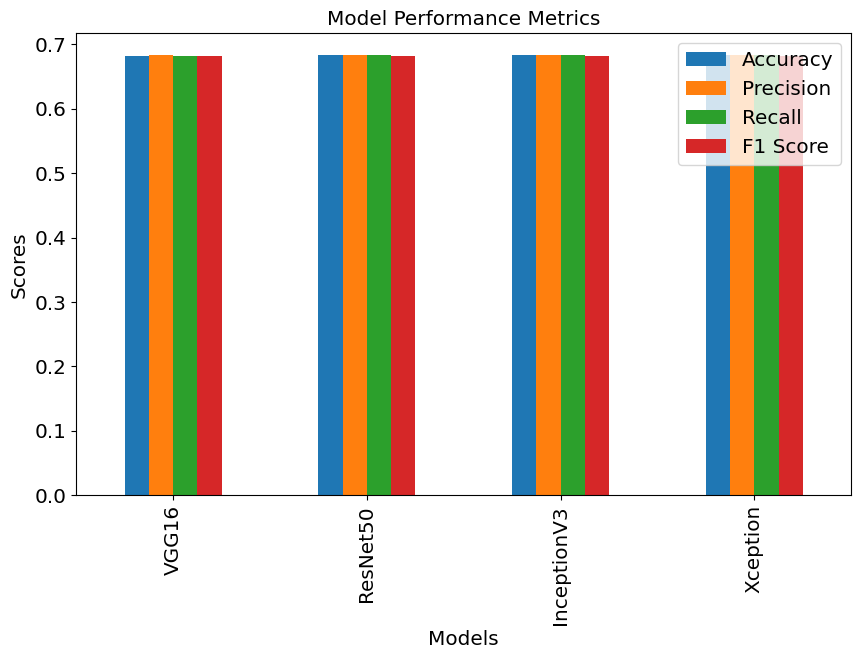

In [48]:


# Plot the DataFrame as a bar chart
df.plot(kind='bar', figsize=(10, 6))

# Add title and labels
plt.title('Model Performance Metrics')
plt.xlabel('Models')
plt.ylabel('Scores')

# Show the plot
plt.show()